## Install hopsworks

## Imports

In [1]:
import os
import requests

from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

#Models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score

import hopsworks
import json
import warnings
warnings.filterwarnings("ignore")

/Users/martinbravodiaz/miniconda3/envs/imdb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read data from Hopsworks

In [2]:
project = hopsworks.login(project="dbillLab1")
fs = project.get_feature_store()

movie_fg = fs.get_feature_group(
    name='tmdb_movies',
    version=2,
)

genres_fg= fs.get_feature_group(
    name='tmdb_movie_genres',
    version=1,
)

2025-01-08 10:39:40,737 INFO: Initializing external client
2025-01-08 10:39:40,738 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 10:39:42,338 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169559


In [3]:
#TA BORT CELL
movie_df=movie_fg.read()
genres_df=genres_fg.read()

selected_columns = ['title','release_year', 'runtime', 'budget',
                                     'original_language', 'imdb_rating', 'first_company','first_producer', 'first_actor',
                                     'production_countries', 'imdb_votes', 'id']
movie_df = movie_df[selected_columns]

merged_df = pd.merge(movie_df, genres_df, on='id', how='inner')

merged_df.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (19.13s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.49s) 


,title,release_year,runtime,budget,original_language,imdb_rating,first_company,first_producer,first_actor,production_countries,...,history,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western
0,Moscow Heat,2004,89.0,0.0,14,2.5,36,387,9712,Russia,...,0,0,0,0,0,0,0,1,0,0
1,A Killing Affair,1977,100.0,0.0,14,6.1,36,5492,20159,United States of America,...,0,0,0,0,0,0,1,0,0,0
2,Top Secret,1952,93.0,0.0,14,6.3,36,8387,16839,United Kingdom,...,0,0,0,0,0,0,0,0,0,0
3,How to Change the World,2014,110.0,0.0,14,7.5,36,1547,17375,"United Kingdom, Canada",...,1,0,0,0,0,0,0,0,0,0
4,The Man Who Could Work Miracles,1936,82.0,0.0,14,6.9,26,385,6987,United Kingdom,...,0,0,0,0,0,0,0,0,0,0


In [4]:
selected_features = movie_fg.select(['title','release_year', 'runtime', 'budget',
                                     'original_language', 'imdb_rating', 'first_company','first_producer', 'first_actor',
                                     'production_countries', 'imdb_votes']).join(genres_fg.select_all(), on=['id'])

selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.21s) 


,title,release_year,runtime,budget,original_language,imdb_rating,first_company,first_producer,first_actor,production_countries,...,history,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western
0,Moscow Heat,2004,89.0,0.0,14,2.5,36,387,9712,Russia,...,0,0,0,0,0,0,0,1,0,0
1,A Killing Affair,1977,100.0,0.0,14,6.1,36,5492,20159,United States of America,...,0,0,0,0,0,0,1,0,0,0
2,Top Secret,1952,93.0,0.0,14,6.3,36,8387,16839,United Kingdom,...,0,0,0,0,0,0,0,0,0,0
3,The Man Who Could Work Miracles,1936,82.0,0.0,14,6.9,26,385,6987,United Kingdom,...,0,0,0,0,0,0,0,0,0,0
4,Them Who?,2015,95.0,0.0,30,6.4,36,11283,7077,Italy,...,0,0,0,0,0,0,0,0,0,0
5,She Freak,1967,83.0,0.0,14,3.6,36,2818,12125,United States of America,...,0,1,0,0,0,0,0,0,0,0
6,More Than Meets the Eye: The Joan Brock Story,2003,120.0,0.0,14,6.4,36,8904,14736,Canada,...,0,0,0,0,0,0,1,0,0,0
7,Five,1951,93.0,0.0,14,6.3,36,967,19473,United States of America,...,0,0,0,0,0,1,0,0,0,0
8,The Manitou,1978,104.0,0.0,14,5.4,36,2963,3706,"Canada, United States of America",...,0,1,0,0,0,1,0,0,0,0
9,Cold Feet,1989,94.0,0.0,14,4.8,36,1936,2138,United States of America,...,0,0,0,0,0,0,0,0,0,0


In [5]:
feature_view = fs.get_or_create_feature_view(
    name='tmdb_fv',
    description="Movie features with imdb rating as the target",
    version=3,
    labels=['imdb_rating'],
    query=selected_features,
)

In [6]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.49s) 


In [7]:
X_train

,title,release_year,runtime,budget,original_language,first_company,first_producer,first_actor,production_countries,imdb_votes,...,history,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western
0,Moscow Heat,2004,89.0,0.0,14,36,387,9712,Russia,2438.0,...,0,0,0,0,0,0,0,1,0,0
1,A Killing Affair,1977,100.0,0.0,14,36,5492,20159,United States of America,125.0,...,0,0,0,0,0,0,1,0,0,0
2,Top Secret,1952,93.0,0.0,14,36,8387,16839,United Kingdom,201.0,...,0,0,0,0,0,0,0,0,0,0
3,The Man Who Could Work Miracles,1936,82.0,0.0,14,26,385,6987,United Kingdom,1647.0,...,0,0,0,0,0,0,0,0,0,0
4,Them Who?,2015,95.0,0.0,30,36,11283,7077,Italy,1911.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25716,The Tenor - Lirico Spinto,2014,114.0,500.0,36,36,12651,21451,"Japan, Serbia, South Korea, United States of A...",151.0,...,0,0,1,0,0,0,0,0,0,0
25717,Madea's Big Happy Family,2011,106.0,25000000.0,14,36,9897,12606,United States of America,8781.0,...,0,0,0,0,0,0,0,0,0,0
25718,The Mechanic,2011,93.0,40000000.0,14,36,11066,20371,United States of America,176443.0,...,0,0,0,0,0,0,0,1,0,0
25719,Twilight of the Warriors: Walled In,2024,125.0,38400000.0,7,36,10298,3308,"China, Hong Kong",6647.0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
drop_list=["id","title","timestamp", "production_countries"]

train_features=X_train.drop(drop_list, axis=1)
test_features=X_test.drop(drop_list, axis=1)

In [9]:
train_features.columns

Index(['release_year', 'runtime', 'budget', 'original_language',
       'first_company', 'first_producer', 'first_actor', 'imdb_votes',
       'action', 'adventure', 'animation', 'comedy', 'crime', 'documentary',
       'drama', 'family', 'fantasy', 'history', 'horror', 'music', 'mystery',
       'romance', 'science_fiction', 'tv_movie', 'thriller', 'war', 'western'],
      dtype='object')

# Training models
XGBoost, RandomForest, Linear Regression, SVR, DecisionTree

In [10]:
xgb_model= XGBRegressor()
rf_model= RandomForestRegressor(random_state=48)
lr_model= LinearRegression()
svr_model= SVR()
dt_model= DecisionTreeRegressor(random_state=48)

models={
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Linear Regression": lr_model,
    "SVR": svr_model,
    "Decision Tree": dt_model
}

model_scores_MSE={
    "XGBoost": 0,
    "Random Forest": 0,
    "Linear Regression": 0,
    "SVR": 0,
    "Decision Tree": 0
}

model_scores_r2={
    "XGBoost": 0,
    "Random Forest": 0,
    "Linear Regression": 0,
    "SVR": 0,
    "Decision Tree": 0
}

## With categorical features
Removed production countries, but keeping original language and the first_producer, first_actor and first company.

In [11]:
for name, model in models.items():
    model.fit(train_features, y_train)
    print(name)
    y_pred= model.predict(test_features)
    mse= mean_squared_error(y_test.iloc[:,0], y_pred)
    print("MSE:", mse)
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    print("R squared:", r2)
    print('_________')
    models[name]= model
    model_scores_MSE[name]= mse
    model_scores_r2[name]= r2

XGBoost
MSE: 0.5094779454232782
R squared: 0.6034133063820155
_________
Random Forest
MSE: 0.5416669755102042
R squared: 0.5783567928908615
_________
Linear Regression
MSE: 0.8287023240921697
R squared: 0.35492337272380636
_________
SVR
MSE: 1.2568727536704811
R squared: 0.021627895467420277
_________
Decision Tree
MSE: 1.0861632653061224
R squared: 0.15451119722328366
_________


## Without categorical features
Removed original language as well since half of the dataset had "en" (english). Removing this feature led to a lower MSE.

In [14]:
drop_list=['original_language']

print("Dropped:", drop_list, "\n")
train_features_without = train_features.drop(drop_list, axis=1)
test_features_without = test_features.drop(drop_list, axis=1)

for name, model in models.items():
    model.fit(train_features_without, y_train)
    print(name)
    y_pred= model.predict(test_features_without)
    mse= mean_squared_error(y_test.iloc[:,0], y_pred)
    print("MSE:", mse)
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    print("R squared:", r2)
    print('_________')
    models[name]= model
    model_scores_MSE[name]= mse
    model_scores_r2[name]= r2

Dropped: ['original_language'] 

XGBoost
MSE: 0.5705394316544234
R squared: 0.5558819595409055
_________
Random Forest
MSE: 0.591078460058309
R squared: 0.5398940145513427
_________
Linear Regression
MSE: 0.843571434255214
R squared: 0.34334899293057675
_________
SVR
MSE: 1.2568753769359167
R squared: 0.02162585347095125
_________
Decision Tree
MSE: 1.1762798833819241
R squared: 0.084362819018169
_________


## Chosen Model

In [16]:
#Chosen model:
model= XGBRegressor()
model.fit(train_features, y_train)
y_pred= model.predict(test_features)
mse= mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)
print('_________')

MSE: 0.5094779454232782
R squared: 0.6034133063820155
_________


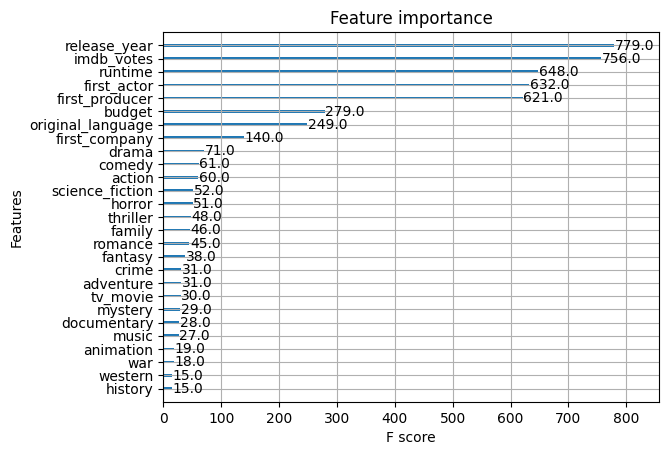

In [17]:
from xgboost import plot_importance

plot_importance(model)
plt.show()

In [18]:
# check some samples

movies = 10

print ("Predictions for", movies, "movies")

for i in range(movies):
    print("Predicted:", y_pred[i], "Actual:", y_test.iloc[i,0])

Predictions for 10 movies
Predicted: 5.857948 Actual: 7.1
Predicted: 6.3983464 Actual: 6.3
Predicted: 5.2628407 Actual: 6.1
Predicted: 4.411699 Actual: 4.2
Predicted: 5.9354286 Actual: 5.9
Predicted: 6.1494517 Actual: 6.1
Predicted: 4.789273 Actual: 4.4
Predicted: 4.68718 Actual: 4.2
Predicted: 4.7766104 Actual: 6.6
Predicted: 6.090134 Actual: 6.3


In [33]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(train_features)
output_schema = Schema(test_features)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [34]:
res_dict = {
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [35]:
mr = project.get_model_registry()

model_dir="model"
model.save_model(model_dir + "/model.json")

# Creating a Python model in the model registry named 'imdb_rating_model'

movie_rating_pred_model = mr.python.create_model(
    name="movie_rating_model_2",
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="Movie Rating (1 to 10) predictor",
)

# Saving the model artifacts to the model registry
movie_rating_pred_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/593443 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/0 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/201 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/3873 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1169559/models/movie_rating_model_2/1


Model(name: 'movie_rating_model_2', version: 1)